# 4. Assignment (Linear and logistic regression)

## 4.1 Objectives

The objectives of this assignment are:

1. To learn to use linear regression for predicting continuously varying target variables
2. To learn to use logistic regression for binary classification
3. To learn to estimate the relative importance of input features

## 4.2 Data understanding

In [71]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from pprint import pprint
  
# fetch dataset 
real_estate_valuation = fetch_ucirepo(id=477) 
  
# data (as pandas dataframes) 
X = real_estate_valuation.data.features 
y = real_estate_valuation.data.targets 
  
# metadata 
pprint(real_estate_valuation.metadata) 
  
# variable information 
print(real_estate_valuation.variables) 

df_x = pd.DataFrame(X)
df_y = pd.DataFrame(y)
df_combined = pd.concat([df_x, df_y], axis=1)


{'abstract': 'The real estate valuation is a regression problem. The market '
             'historical data set of real estate valuation are collected from '
             'Sindian Dist., New Taipei City, Taiwan. ',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': 'The market historical data set of real estate '
                                'valuation are collected from Sindian Dist., '
                                'New Taipei City, Taiwan. The â€œreal estate '
                                'valuationâ€\x9d is a regression problem. The '
                                'data set was randomly split into the training '
                                'data set (2/3 samples) and the

In [46]:
df_combined

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [47]:
df_combined.describe(include='all')

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [48]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            414 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


The dataset contains 414 records and 8 columns.There are no data with missing values.  
Structure of the data:

- `No`: Record number.
- `X1 transaction date`: Transaction date (in year and fraction of a month format).
- `2 house age: Age of the house in years`.
- `X3 distance to the nearest MRT station`: Distance to the nearest MRT station (in meters).
- `X4 number of convenience stores`: Number of stores in the neighborhood.
- `X5 latitude`: Latitude of the property location.
- `X6 longitude`: Longitude of the property location.
- `Y house price of unit area` : The price of the property per unit area (target variable).

## 4.3 Data preparation

First, let's see what the data set looks like

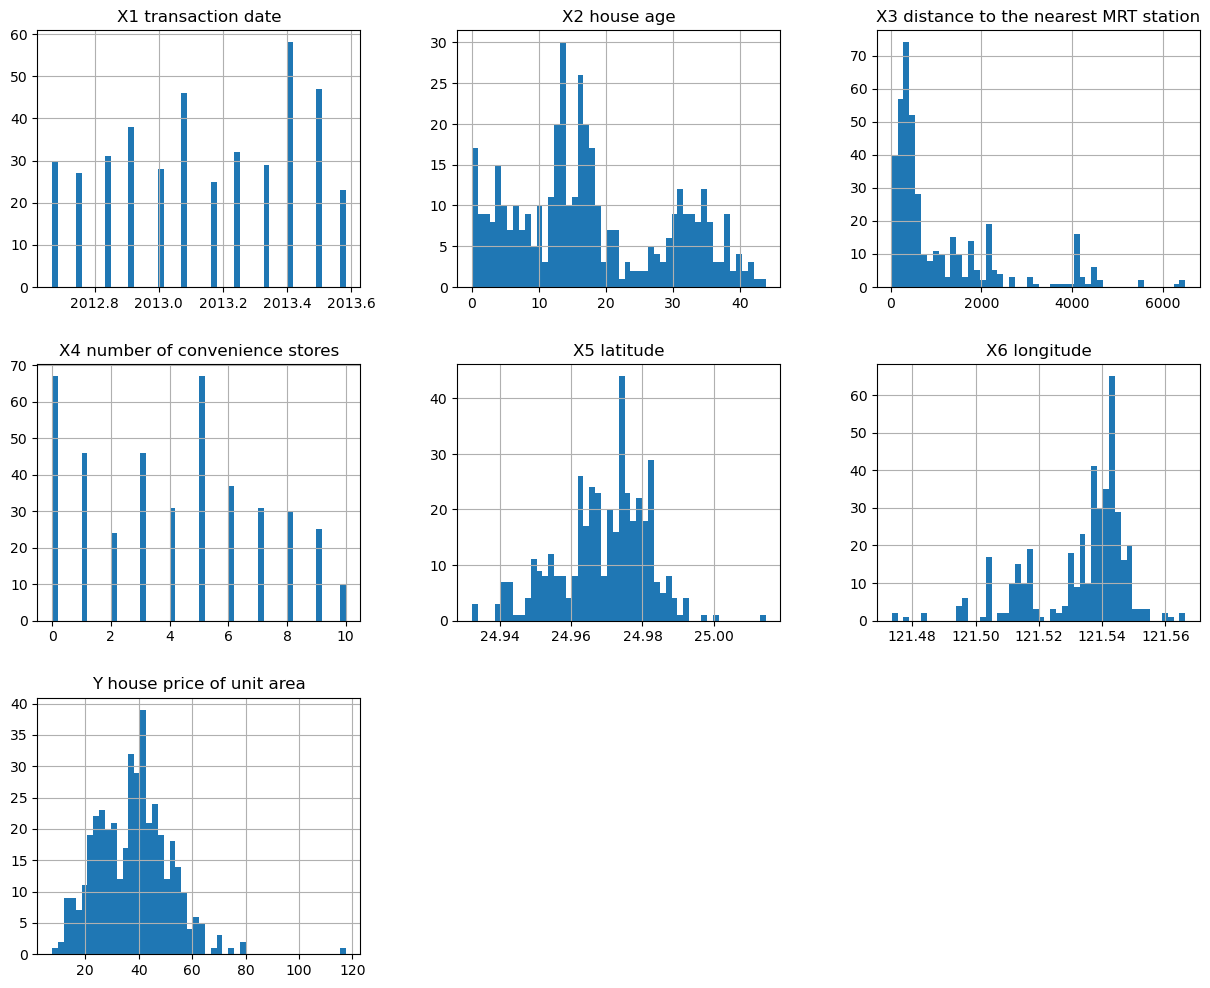

In [49]:
df_combined.hist(bins=50, figsize=[15,12]);

Проверим данные на наличие корреляции

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Рассчитываем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                                  Feature           VIF
0                     X1 transaction date  4.253389e+07
1                            X2 house age  3.471392e+00
2  X3 distance to the nearest MRT station  4.261358e+00
3         X4 number of convenience stores  4.748152e+00
4                             X5 latitude  6.178301e+06
5                            X6 longitude  4.198817e+07


One of the features has a high multi-collinearity coefficient. Since this is an educational project, we will not remove it, but in real life, multi-collinearity coefficients should be taken into account and their impact on the model should be assessed.

Linear regression is sensitive to the scale of features, especially if the ranges of values differ significantly. For example, the distance to the metro station (in meters) and the number of stores have different scales. It is recommended to normalize or standardize the features to improve the model's convergence. In this case, we will use standardization, as it is less sensitive to outliers.

But before we can standardize the data, we need to first split the data into training and validation sets. And before that, we should set aside a test portion for the final assessment of the model's performance.

In [51]:
from sklearn.model_selection import train_test_split
# Dataset separation
# 80% of the data will be used for training and 20% for testing
work_data, test_data, work_targets, test_targets = train_test_split(df_x, df_y, test_size=0.2)

# Then we will divide the work data into training and validation data
train_data, val_data, train_targets, val_targets = train_test_split(work_data, work_targets, test_size=0.2)

Next, we will standardize the obtained datasets.

In [52]:
from sklearn.preprocessing import StandardScaler
# Standardization of data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.fit_transform(val_data)
test_data = scaler.fit_transform(test_data)
work_data = scaler.fit_transform(work_data)

Since we will also be building a logistic regression model, we will convert the target variable to a binary format. If the price of the property is above the median price, the target variable will be 1, otherwise 0. This means that the model will predict whether the price is above or below the median.

In [53]:
median_price = train_targets.median()
train_targets_binary = (train_targets > median_price).astype(int)
val_targets_binary = (val_targets > median_price).astype(int)
test_targets_binary = (test_targets > median_price).astype(int)
work_targets_binary = (work_targets > median_price).astype(int)

Let's take a look at the data after the transformations.

In [54]:
train_targets_binary

,Y house price of unit area
410,1
133,1
346,0
317,0
286,1
...,...
159,0
325,0
107,0
59,1


## 4.4 Modeling

### 4.4.1 Linear regression

Let's create a linear regression model and train it on the training data.

In [55]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
# Create a model
model_linear = LinearRegression(fit_intercept = True)
model_linear.fit(train_data, train_targets)

# Predictions
predictions = model_linear.predict(val_data)

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate the error metrics
mse = mean_squared_error(val_targets, predictions)
mae = mean_absolute_error(val_targets, predictions)
R2 = r2_score(val_targets, predictions)

In [69]:
# Feature importance
print("b =", model_linear.intercept_[0])

coefficients = pd.DataFrame({
    'Feature': X.columns, 
    'Coefficient': model_linear.coef_[0]
})
coefficients.index = pd.RangeIndex(start=1, stop=len(coefficients) + 1, step=1)

print(coefficients)
print("R^2 =", R2)
print("MSE =", mse)
print("MAE =", mae)

b = 37.9761363636362
                                  Feature  Coefficient
1                     X1 transaction date     0.655949
2                            X2 house age    -3.428287
3  X3 distance to the nearest MRT station    -5.131344
4         X4 number of convenience stores     3.863446
5                             X5 latitude     2.259958
6                            X6 longitude     0.012417
R^2 = 0.3973719491629081
MSE = 176.08473404663062
MAE = 7.865784865018274


### 4.4.2 Logistic regression

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import column_or_1d

# Transform the target variable to 1d array
work_targets_binary = column_or_1d(work_targets_binary, warn=True)

# Create a model
model_reg = LogisticRegression(solver='lbfgs').fit(work_data, work_targets_binary)

print("Coefficients: ",model_reg.coef_)
print("Intercept: ", model_reg.intercept_)

Coefficients:  [[ 0.15566902 -0.83815816 -2.63900778  0.61964166  0.73411434  0.08357706]]
Intercept:  [-1.02187904]


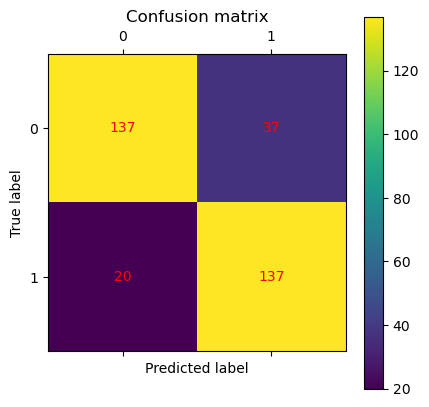

In [59]:
# cross-validation
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(estimator=model_reg, X=work_data, y=work_targets_binary, cv=10)

# confusion matrix
cm = confusion_matrix(work_targets_binary, y_pred)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [60]:
print(classification_report(work_targets_binary, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       174
           1       0.79      0.87      0.83       157

    accuracy                           0.83       331
   macro avg       0.83      0.83      0.83       331
weighted avg       0.83      0.83      0.83       331



The model seems to predict the outcome quite well, with an accuracy of 0.83. Contransting this to the performance of a random classifier, which would have an accuracy of 0.5, the model seems to be doing a decent job.

## 4.5 Evaluation

### 4.5.1 Linear regression

Let's evaluate the accuracy of the linear regression model on the test dataset:

In [61]:
# model_linear.fit(work_data, work_targets) ???
predictions = model_linear.predict(test_data)

In [62]:
# Calculate the error metrics
mse = mean_squared_error(test_targets, predictions)
mae = mean_absolute_error(test_targets, predictions)
R2 = r2_score(test_targets, predictions)

Let's take a look at the coefficients and feature importance.

In [63]:
# Feature importance
print("b =", model_linear.intercept_[0])

coefficients = pd.DataFrame({
    'Feature': X.columns, 
    'Coefficient': model_linear.coef_[0]
})
coefficients.index = pd.RangeIndex(start=1, stop=len(coefficients) + 1, step=1)

print(coefficients)
print("R^2 =", R2)
print("MSE =", mse)
print("MAE =", mae)

b = 37.9761363636362
                                  Feature  Coefficient
1                     X1 transaction date     0.655949
2                            X2 house age    -3.428287
3  X3 distance to the nearest MRT station    -5.131344
4         X4 number of convenience stores     3.863446
5                             X5 latitude     2.259958
6                            X6 longitude     0.012417
R^2 = 0.3973719491629081
MSE = 176.08473404663062
MAE = 7.865784865018274


Let's take a look at the coefficients. The coefficient `W` is a vector of weights for each feature. The coefficient `b` is the bias term.
Feature importance can be estimated by the magnitude of the weights. The larger the weight, the more important the feature.
- `X4 number of convenience stores` **(3,86)** is the most important feature. It has the largest weight. The more stores in the neighborhood, the higher the price.
- `X3 distance to the nearest MRT station` **(-5,13)** is negatively correlated with the target variable. The closer the metro station, the higher the price.
- `X2 house age` **(-3,42)** is too negatively correlated with the target variable. The older the house, the lower the price. 
- `X1 transaction date` **(0,66)** is positively correlated with the target variable. The more recent the transaction, the higher the price. But the weight not so big.
- `X5 latitude` **(2,25)** is positively correlated with the target variable. The higher the latitude, the higher the price. It has a pretty big weight.
- `X6 longitude` **(0,012)** is positively correlated with the target variable. It has a pretty small weight and is not so important.This may be due to the geographical peculiarities of the studied territory

Based on the presented test results for the linear regression, we can draw the following conclusions about the model's effectiveness:

- R^2 (coefficient of determination) is 0.3974, meaning the model explains approximately 39.74% of the variation in the data. This indicates a weak predictive capability of the model, as more than half of the variation remains unexplained.
- MSE (Mean Squared Error) is 176.084, which is quite high. This suggests a significant discrepancy between predicted and actual values.
- MAE (Mean Absolute Error) is 7.86, which also indicates a substantial deviation of predictions from real values.

Conclusions:

1. The effectiveness of this linear regression is low.
2. The model doesn't capture the patterns in the data well enough.
3. There may be non-linear relationships in the data that the linear model cannot reflect.
4. It's necessary to consider alternative modeling methods or improve the current model.

### 4.5.2 Logistic regression

Let's evaluate the accuracy of the logistic regression model on the test dataset:

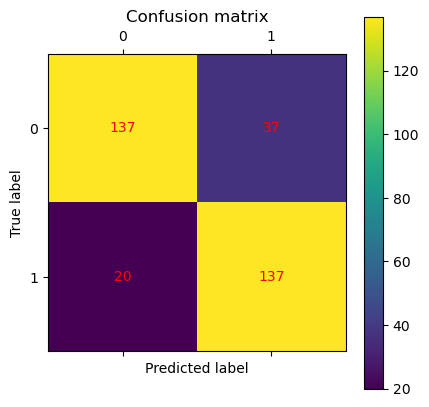

In [64]:
# Predicting on test data
y_test_pred = model_reg.predict(test_data)

# Confusion matrix
cm_test = confusion_matrix(test_targets_binary, y_test_pred)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [65]:
# Classification report (precision, recall, F1-score)
print(classification_report(test_targets_binary, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.84      0.83      0.84        46

    accuracy                           0.82        83
   macro avg       0.82      0.82      0.82        83
weighted avg       0.82      0.82      0.82        83



The model seems to predict the outcome quite well, with an accuracy of 0.82. Contrasting this to the performance of a random classifier, which would have an accuracy of 0.5, the model seems to be doing a decent job.

In [66]:
from sklearn.metrics import roc_curve, auc

y_prob = model_reg.predict_proba(test_data)[:, 1]
fpr, tpr, thresholds = roc_curve(test_targets_binary, y_prob)
roc_auc = auc(fpr, tpr)

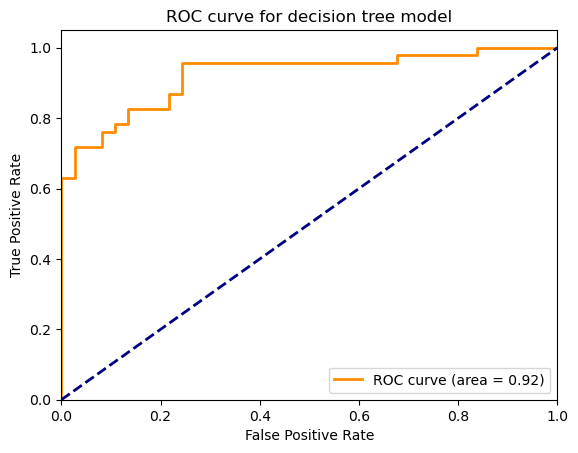

In [67]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for decision tree model')
plt.legend(loc="lower right")
plt.show()

The ROC curve shows that the model performs well in distinguishing between the two classes. The area under the ROC curve is 0.92, which is close to the maximum value of 1. This indicates that the model has a good predictive capability.  
A stepped curve indicates that the model is working with a relatively small set of discrete data. This may mean that your data set has a limited number of unique predicted probabilities or a small number of samples. Each 'step' represents a change in the ratio of true positives to false positives at a given threshold. Steps indicate that there are a limited number of effective thresholds.

Let's look at permutation importance to estimate the importance of each feature:

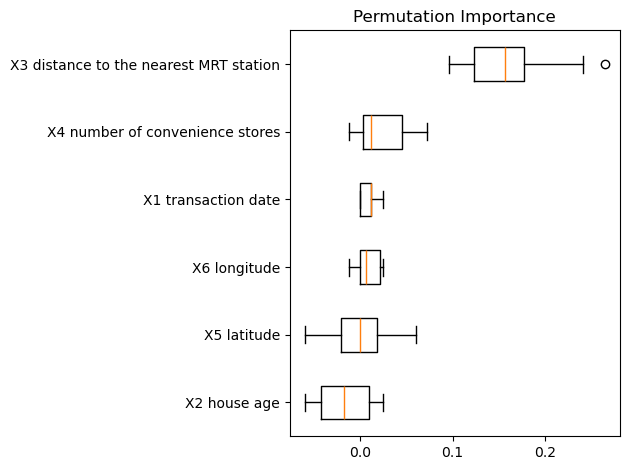

In [68]:
# feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(model_reg, test_data, test_targets_binary, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

The most important features for the logistic regression model are:
1. `X3 distance to the nearest MRT station` — has the highest importance. This indicates that the distance to the nearest MRT station has the most significant influence on the target variable.

2. `X4 number of convenience stores` — is also important but slightly less so compared to X3. This suggests that the number of convenience stores in the area affects the target variable but not as strongly as the distance to the MRT station.

3. `X1 transaction date` — has very little importance. This means that the transaction date has minimal impact on the target variable.

4. `X6 longitude and X5 latitude` — the coordinates of longitude and latitude have moderate importance, which makes sense since the location of a property typically affects its value.

5. `X2 house age` — the age of the house has the least impact, but there is still some influence.

Overall, the most significant features for the model are X3 and X4. The remaining features have less influence, but their contribution should not be completely ignored.

## 4.6 Conclusion

In this assignment, we have built linear and logistic regression models to predict the price of real estate properties. We have evaluated the models' performance on test data and estimated the importance of input features. Here are some key findings:
1. Dataset:
- One of the features has a high multi-collinearity coefficient, which should be taken into account in further analysis.
2. Linear regression:
- The linear regression model has a low predictive capability, explaining only 39,74% of the variation in the data.
- The model has a high Mean Squared Error (MSE) of 176.084 and Mean Absolute Error (MAE) of 7.86, indicating a significant discrepancy between predicted and actual values.
- The most important feature is distance to the nearest MRT station in the neighborhood, followed by the number of convenience stores and house age.
- The model does not capture the patterns in the data well enough, suggesting the need for alternative modeling methods or model improvements.
3. Logistic regression:
- The logistic regression model has an accuracy of 0.82, indicating a good predictive capability.
- ROC curve analysis shows that the model performs well in distinguishing between the two classes. The area under the ROC curve is 0.92, which is close to the maximum value of 1.
- The most important features is the distance to the nearest MRT station as well as in the linear regression model.
- The model is sensitive to changes in the most important features, indicating their significant impact on the model's predictions.
- The feature `X3 distance to the nearest MRT station` has  outlier value, which may indicate the instability of their influence on the model.